# Inverse trasform sampling

In [1]:
import timeit
import arviz as az
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy import stats
from matplotlib import pyplot as plt

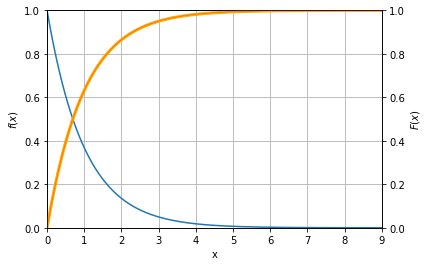

In [166]:
x_max = 9
x = np.linspace(0, x_max, 9000)

f = lambda x : np.exp(-x)
F = lambda x: 1 - np.exp(-x)
F_inv = lambda x : -np.log(1 - x)

delta = x[1] - x[0]
F_emp = delta * np.cumsum(f(x))
F_emp.shape

fig, ax1 = plt.subplots() 
plt.plot(x, f(x))
plt.ylabel('$f(x)$')
plt.xlabel('x')
plt.xlim([0, x_max])
plt.ylim([0, 1])
plt.grid()
ax2 = ax1.twinx()
ax2.plot(x, F(x), color='orange', lw=3)
ax2.set_ylabel('$F(x)$')
ax2.set_xlim([0, x_max])
ax2.set_ylim([0, 1])
ax2.plot(x, F_emp, color='red', lw=0.2)

In [85]:
def plot_hist(samples):
    plt.figure()
    hist = plt.hist(samples, bins=100, density=True, color='orange', edgecolor='white')  
    plt.plot(hist[1], f(hist[1]), color='red', lw=2)
    plt.xlim([0, x_max])
    plt.ylim([0, 1])
    plt.grid()

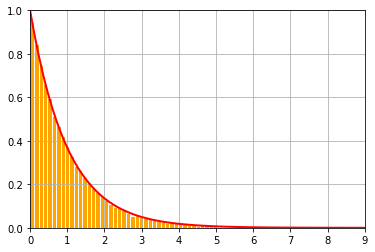

In [169]:
rnd = np.random.uniform(0, 1, 100000)
samples = F_inv(rnd)
plot_hist(samples)

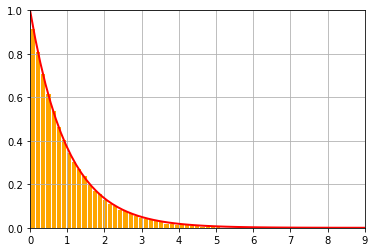

In [170]:
samples = []
for itt in range(100000):
    rnd = np.random.uniform()
    samples.append(F_inv(rnd))

plot_hist(samples)

In [77]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

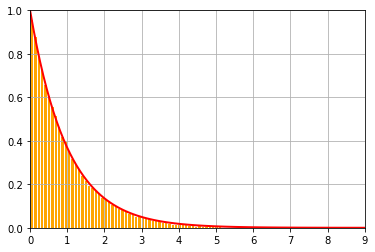

In [171]:
samples = []
for itt in range(100000):
    rnd = np.random.uniform()
    idx = find_nearest(F(x), rnd)
    samples.append(x[idx])

plot_hist(samples)

# Accept-reject sampling

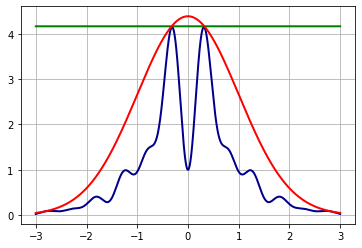

In [10]:
num_grids = 10000
x = np.linspace(-3, 3, 6 * num_grids)
f = lambda x : np.exp(-x ** 2 / 2) * (np.square(np.sin(6 * x)) + 3 * np.square(np.cos(x)) * np.square(np.sin(4 * x)) + 1)
g1 = np.vectorize(lambda x : 1/6)
g2 = lambda x: stats.norm(loc=0, scale=1).pdf(x)

C1 = 25
C2 = 11

plt.plot(x, f(x), color='darkblue', lw=2)
plt.plot(x, C1 * g1(x), color='green', lw=2)
plt.plot(x, C2 * g2(x), color='red', lw=2)
plt.grid()


In [11]:
delta = x[1] - x[0]
area = delta * np.sum(f(x))
print(area)

5.879613782199517


In [87]:
def plot_hist(samples, area):
    plt.figure()
    hist = plt.hist(samples, bins=100, density=True, color='orange', edgecolor='white')  
    plt.plot(hist[1], f(hist[1]) / area, color='red', lw=2)
    plt.grid()

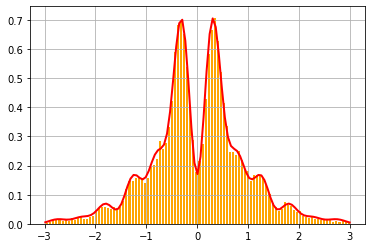

In [13]:
itts = 100000
samples = []

for itt in range(itts):
    x = np.random.uniform(-3, 3)
    u = np.random.uniform(0, C1 * g1(x))
    
    if u < f(x):
        samples.append(x)
    
plot_hist(samples, area)

In [14]:
def acc_rej_sampler(gaussian, C, itts=100_000):
    if gaussian:
        x = np.random.randn(itts)
        u = np.random.uniform(0, C * g2(x))
    else:
        x = np.random.uniform(-3, 3, itts)
        u = np.random.uniform(0, C * g1(x))

    samples = x[u < f(x)]
    return samples

In [15]:
samples_gauss = acc_rej_sampler(True, C1)
samples_unif = acc_rej_sampler(True, C2)

In [16]:
print('acceptance rate for uniform proposal function: {}%'.format(100 * len(samples_unif) / itts))
print('acceptance rate for normal proposal function: {}%'.format(100 * len(samples_gauss) / itts))

acceptance rate for uniform proposal function: 53.839%
acceptance rate for normal proposal function: 23.55%


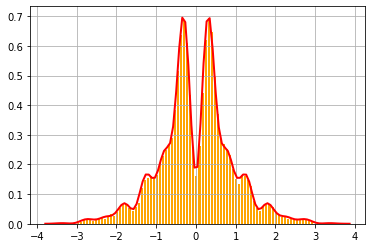

In [17]:
plot_hist(samples_unif, area)

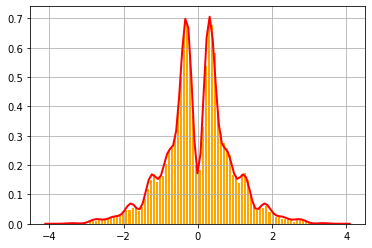

In [18]:
plot_hist(samples_gauss, area)

In [83]:
def plot_corr(samples):
    plt.figure()
    plt.scatter(samples[:-1], samples[1:], s=1)
    plt.xlabel('Previous Sample', fontsize=16)
    plt.ylabel('Current Sample', fontsize=16)
    corr = round(stats.pearsonr(samples[:-1], samples[1:])[0], 2)
    plt.title('Correlation: {}'.format(corr, fontsize=20))

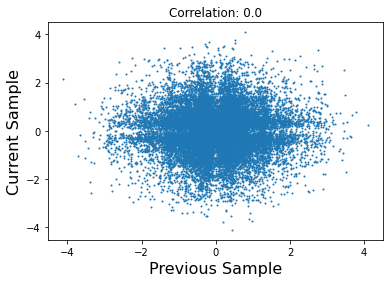

In [66]:
plot_corr(samples_gauss)

# MCMC sampling: Metropolis

In [113]:
def metroplois_sampler(gaussian=True, scale=1, itts=1_000_000):
    samples = [0]
    num_accept = 0
    for itt in range(itts - 1):
        curr = samples[-1]
        if gaussian:
            x = np.random.normal(loc=curr, scale=scale)
        else:
            x = np.random.uniform(-3, 3)
        ratio = f(x) / f(curr)
        #probability of accepting this candidate
        prob = min(1, ratio)
        if np.random.random() <= prob:
            samples.append(x)
            num_accept += 1
        else:
            samples.append(curr)
    return samples, num_accept

In [77]:
starttime = timeit.default_timer()       
samples_normal, num_accept_normal = metroplois_sampler()
print("The time difference is : {} sec".format(timeit.default_timer() - starttime))        

starttime = timeit.default_timer()       
samples_uniform, num_accept_uniform = metroplois_sampler(False)
print("The time difference is : {} sec".format(timeit.default_timer() - starttime))        

The time difference is : 19.475010811001994 sec
The time difference is : 19.06368514399219 sec


In [79]:
burn_in = int(itts / 100)
kept_samples_normal = samples_normal[burn_in:]
kept_samples_uniform = samples_uniform[burn_in:]

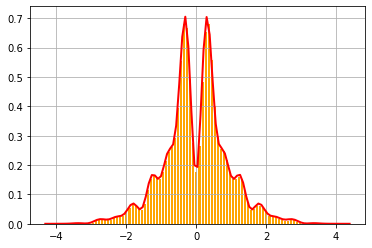

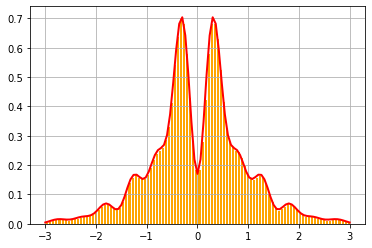

In [88]:
plot_hist(kept_samples_normal, area)
plot_hist(kept_samples_uniform, area)

In [89]:
print('acceptance rate for normal proposal function: {}%'.format(100 * num_accept_normal / len(kept_samples_normal)))
print('acceptance rate for uniform proposal function: {}%'.format(100 * num_accept_uniform / len(kept_samples_uniform)))

acceptance rate for normal proposal function: 59.11501501501502%
acceptance rate for uniform proposal function: 43.177877877877876%


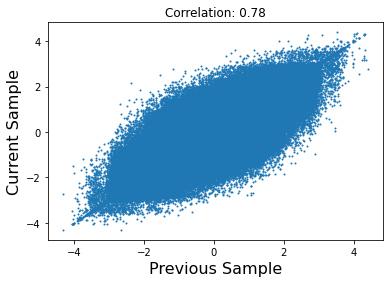

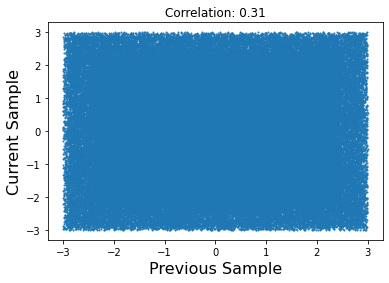

In [84]:
plot_corr(kept_samples_normal)
plot_corr(kept_samples_uniform)

### MCMC: Another example[](https://gist.github.com/ColCarroll/f6985375d3029c0651a4f41e83f99499)

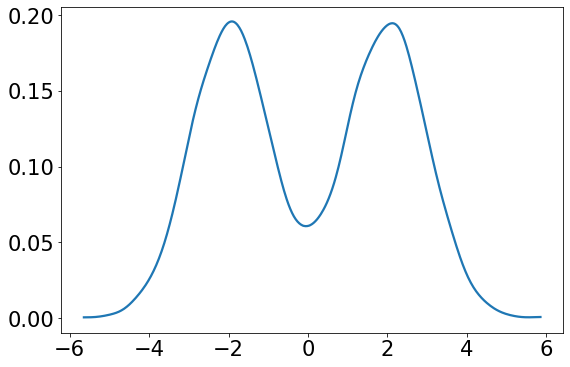

In [2]:
FIGSIZE = (9, 6)

class MixtureOfGaussians:
    """Two standard normal distributions, centered at +2 and -2."""
    def __init__(self):
        self.components = [stats.norm(-2, 1), stats.norm(2, 1)]
        self.weights = np.array([0.5, 0.5])
    
    def pdf(self, x):
        return self.weights.dot([component.pdf(x) for component in self.components])
    
    def rvs(self, size=1):
        idxs = np.random.randint(0, 2, size=size)
        result = np.empty(size)
        for idx, component in enumerate(self.components):
            spots, = np.where(idxs==idx)
            result[spots] = component.rvs(size=spots.shape[0])
        return result
    
az.plot_kde(MixtureOfGaussians().rvs(10_000), figsize=FIGSIZE);

In [3]:
def metropolis_sample(pdf, *, steps, step_size, init=0.):
    """Metropolis sampler with a normal proposal."""
    point = init
    samples = []
    for _ in range(steps):
        proposed = stats.norm(point, step_size).rvs()
        if np.random.rand() < pdf(proposed) / pdf(point):
            point = proposed
        samples.append(point)
    return np.array(samples)

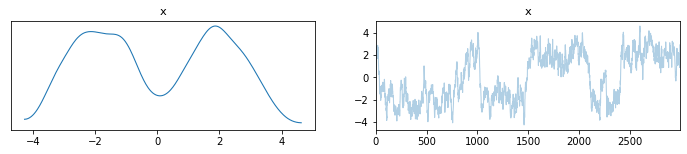

In [29]:
seed = 0
np.random.seed(seed)
samples = metropolis_sample(MixtureOfGaussians().pdf, steps=3_000, step_size=0.4)
az.plot_trace(samples);

## Falling Animation

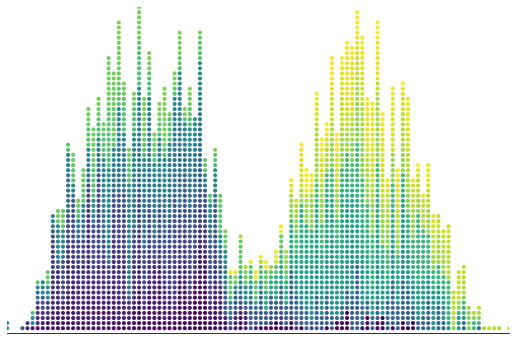

In [31]:
hi, lo = samples.max(), samples.min()
# bins values
x = np.linspace(lo, hi, 100)
#  indices of the bins to which each value in samples array belongs
bins = np.digitize(samples, x, right=True)

counter = np.zeros_like(bins)  # y values
counts = np.zeros_like(x)      # keep track of how points are already in each bin
for idx, bin_ in enumerate(bins):
    counts[bin_] += 1
    counter[idx] = counts[bin_]
counter = counter / counter.max()


# Mess with plot styles here, since it is cheaper than animating
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_ylim(0, 1)
ax.set_xlim(bins.min(), bins.max())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xticks([])
ax.get_yaxis().set_visible(False)
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, bins.shape[0]))


ax.scatter(bins, counter, marker='.', facecolors=colors);

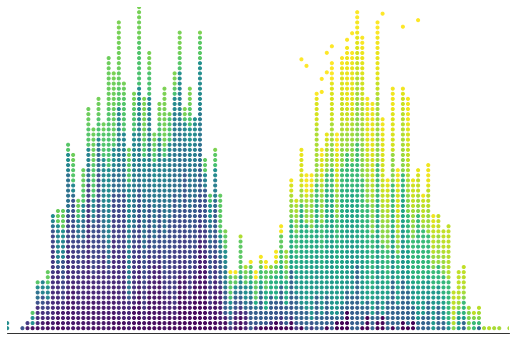

In [32]:
fig, ax = plt.subplots(figsize=FIGSIZE)
xdata, ydata = [], []
ln = ax.scatter([], [], marker='.', animated=True)
cmap = plt.get_cmap('viridis')

def init():
    ax.set_xlim(bins.min(), bins.max())
    ax.set_ylim(0, 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xticks([])
    ax.get_yaxis().set_visible(False)
    return ln,

def update(idx):
    xdata.append(bins[idx])
    ydata.append(counter[idx])
    colors = cmap(np.linspace(0, 1, len(xdata)))
    offset = (np.arange(idx + 1) - idx + 49) / 50
    #offset = np.zeros_like(idx + 1) 
    y = np.maximum(ydata, offset)
    ln.set_offsets(np.array([xdata, y]).T)
    ln.set_facecolors(colors)
    return ln, 

anim = FuncAnimation(fig, update, frames=np.arange(bins.shape[0]),
                     init_func=init, blit=True, interval=20)
HTML(anim.to_html5_video())


## Fire hose animation

In [24]:
class Point:
    def __init__(self, x, y, steps=50):
        self.x = x
        self.y = y
        self.v_x = x
        self.v_y = y + 0.5
        self.step = 0
        self.steps = steps
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.step == self.steps:
            return self.x, self.y
        t = self.step / self.steps
        x = self.v_x * t
        y = -0.5 * t * t + self.v_y * t
        self.step += 1
        return x, y

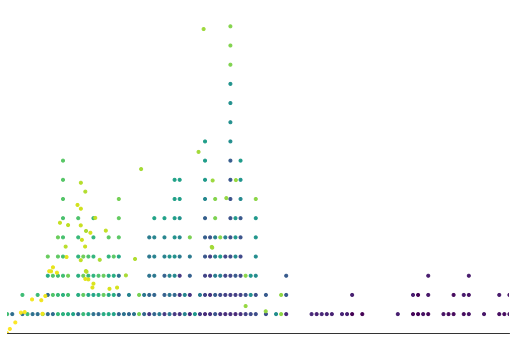

In [25]:
fig, ax = plt.subplots(figsize=FIGSIZE)
xdata, ydata = [], []
ln = ax.scatter([], [], marker='.', animated=True)
cmap = plt.get_cmap('viridis')
points = []

def init():
    ax.set_xlim(bins.min(), bins.max())
    ax.set_ylim(0, 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xticks([])
    ax.get_yaxis().set_visible(False)
    return ln,

def update(idx):
    points.append(Point(bins[idx], counter[idx]))
    colors = cmap(np.linspace(0, 1, len(points)))
    ln.set_offsets(np.array([next(p) for p in points]))
    ln.set_facecolors(colors)
    return ln, 

anim = FuncAnimation(fig, update, frames=np.arange(bins.shape[0]),
                     init_func=init, blit=True, interval=20)
HTML(anim.to_html5_video())
